In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set up plotting colors
"""
sns.set(rc={'axes.facecolor'   : '#202020', 
            'axes.labelcolor'  : '#e0e0e0',
            'axes.edgecolor'   : '#e0e0e0',
            'axes.grid'        :  False,
            'text.color'       : '#e0e0e0', 
            'figure.facecolor' : '#202020',
            'figure.edgecolor' : '#202020',
            'xtick.color'      : '#e0e0e0',
            'ytick.color'      : '#e0e0e0',
            'legend.fancybox'  : 'true'
           })
"""
octal_seq = [sns.hls_palette(12, 0, .5, .5)[i] for i in [0,1,2,4,7,9]]
octal_cat = [sns.hls_palette(12, 0, .5, .5)[i] for i in [7,1,4,0,9,2]]
octal_unity = [sns.hls_palette(12, 0, .5, .5)[i] for i in [4]]
sns.set_palette(octal_cat)

In [3]:
df = pd.DataFrame()
for yr in range(2015,2018):
    temp_df = pd.read_csv('./data/skaters_season{year}.csv'.format(year=yr),header=1)
    temp_df['year'] = yr
    df = df.append(temp_df, ignore_index=True)

In [4]:
# convert all column headers to lowercase
for col in df.columns:
    df.rename(columns={col:str(col).lower()}, inplace=True)
    
df['player'] = df['player'].apply(lambda l: str.split(l,'\\')[0])
#df['pos'] = df['pos'].apply(lambda l: str(l).lower())
#df['tm'] = df['tm'].apply(lambda l: str(l).lower())

In [5]:
# fix special teams stats column names
df.rename(columns={'ev':'evg'}, inplace=True)
df.rename(columns={'pp':'ppg'}, inplace=True)
df.rename(columns={'sh':'shg'}, inplace=True)

df.rename(columns={'ev.1':'eva'}, inplace=True)
df.rename(columns={'pp.1':'ppa'}, inplace=True)
df.rename(columns={'sh.1':'sha'}, inplace=True)

# define the respective points
df['evp'] = df['evg'] + df['eva']
df['ppp'] = df['ppg'] + df['ppa']
df['shp'] = df['shg'] + df['sha']

# drop team, age, yearly shooting percentage, average time on ice, faceoff %, and year
df = df.drop(['tm', 'age', 's%', 'atoi', 'fo%', 'year'], axis=1)

In [6]:
df.columns

Index([u'player', u'pos', u'gp', u'g', u'a', u'pts', u'+/-', u'pim', u'ps',
       u'evg', u'ppg', u'shg', u'gw', u'eva', u'ppa', u'sha', u's', u'toi',
       u'blk', u'hit', u'fow', u'fol', u'evp', u'ppp', u'shp'],
      dtype='object')

In [7]:
# group positions by forward/defense
df['fd'] = df['pos'].apply(lambda l: 'd' if l=='D' else 'f' )
df = df.drop('pos', axis=1)

In [8]:
# get totals across all years
idx = ['player', 'fd']
data = [df.groupby(idx)['gp'].sum().index]

for stat in df.drop(idx, axis=1).columns.values:
    data.append(df.groupby(idx)[stat].sum())
    
col_labels = ['name, pos'] + list(df.drop(idx, axis=1).columns.values)
grouped_df = pd.DataFrame(np.array(data).transpose(), columns=col_labels)

grouped_df['name'] = grouped_df['name, pos'].apply(lambda l: l[0])
grouped_df['pos'] = grouped_df['name, pos'].apply(lambda l: l[1])

In [9]:
# drop name,pos and make name, pos first
grouped_df = grouped_df[['name', 'pos'] + list(df.drop(idx, axis=1).columns.values)]

In [10]:
# define a minimum number of minutes played
# drop all nas
grouped_df = grouped_df.dropna()
grouped_df = grouped_df[grouped_df.toi > 500]

In [11]:
# define average time on ice, shooting percentage, face off % over the three seasons
grouped_df['atoi'] = grouped_df.toi / grouped_df.gp
grouped_df['s%'] = 100 * grouped_df.g / (grouped_df.s)
# add a small number to avoid dividing by zero, it won't significantly change fo%
grouped_df['fo%'] = (grouped_df.fow.divide(grouped_df.fol + grouped_df.fow + 1E-8)).fillna(0)

In [12]:
# per-game/minute averages
cum_stats = ['g', 'a', 'pts', '+/-', 'pim', 'evg', 'ppg', 'shg', 'eva', 'ppa', 'sha', 's', 'blk', 'hit', 'evp', 'ppp', 'shp']
for stat in cum_stats:
    grouped_df[str(stat)+'/g'] = grouped_df[stat] / grouped_df.gp
    grouped_df[str(stat)+'/min'] = grouped_df[stat] / grouped_df.toi

In [13]:
# percent of points that are goals
grouped_df['g/p'] = 100 * grouped_df['g'] / (grouped_df['pts'])

# percent of goals on powerplays 
# add one to avoid dividing by zero, ppg is 0 when g is 0
grouped_df['ppg%'] = 100 * (grouped_df['ppg'] / (grouped_df['g']+1))

# percent of points on powerplays 
# add one to avoid dividing by zero, ppg is 0 when g is 0
grouped_df['ppp%'] = 100 * (grouped_df['ppp'] / (grouped_df['pts']+1))

In [14]:
for stat in list(grouped_df.columns.values)[3:]:
        grouped_df[stat] = grouped_df[stat].astype(float)

In [15]:
# seperate the forwards and defensemen
forwards = grouped_df[grouped_df.pos=='f'].drop('pos', axis=1)
defense = grouped_df[grouped_df.pos=='d'].drop('pos', axis=1)

In [16]:
cluster_stats = ['fo%', 'g/min', 'a/min', 's/min', 'hit/min', 'blk/min', 'pim/min', 'g/p']

In [17]:
def cluster_players(df, cluster_stats,  n_clusters=5, weights=None, verbose=False):
    #scale
    scaled_stats = preprocessing.scale(df[cluster_stats])
    if weights:
        scaled_stats *= np.array(weights)
    
    # cluster
    k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    k_means.fit(scaled_stats)
    
    # add cluster to df
    df['cluster'] = k_means.labels_

    # get cluster centroids
    centers = k_means.cluster_centers_
    center_df = pd.DataFrame(centers, columns=cluster_stats)

    # get the mean values for each stat
    means = []
    for col in range(centers.shape[1]):
        means.append(centers[:,col].mean())

    # find values relative to mean
    rel_values = centers - np.array(means)
    rel_df = pd.DataFrame(rel_values, columns=cluster_stats)

    # print results
    if verbose:
        print("\nK-Means Clustering of NHL Players:\n")
        for i in range(0,len(df.cluster.value_counts())):
            print('Group:', i, '/', len(df.cluster.value_counts())-1)
            print('{stat:15}{val:8}  {rank:4}'.format(stat='Stat', val='Value', rank='Rank'))
            for j in range(len(cluster_stats)):
                print('{stat:15}{val:8.2f}  {rank:4.0f}/{of}'.format(stat=cluster_stats[j],
                                                 rank=rel_df.rank(ascending=False).iloc[i].values[j],
                                                 val=rel_df.iloc[i].values[j],
                                                 of=len(rel_df)))
            print('\nTypical players ({:.1%}):'.format(len(df[df.cluster==i])/len(df.cluster)))
            for j in range(5):
                if j < len(df[df.cluster==i]):
                    print('-',df[df.cluster==i].sort_values(by='atoi', ascending=False)['name'].head().values[j])
            print('--------------------\n')
    return df

In [18]:
forwards = cluster_players(forwards, cluster_stats, 6, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 5)
Stat           Value     Rank
fo%                0.44     3/6
g/min              0.16     3/6
a/min             -0.52     4/6
s/min             -0.00     4/6
hit/min            0.31     2/6
blk/min            0.18     3/6
pim/min           -0.43     2/6
g/p                0.90     1/6

Typical players (0.0%):
('-', 'Adam Henrique')
('-', 'Andrew Ladd')
('-', 'David Backes')
('-', 'Brandon Sutter')
('-', 'Mike Fisher')
--------------------

('Group:', 1, '/', 5)
Stat           Value     Rank
fo%               -0.05     4/6
g/min              1.66     1/6
a/min              0.85     2/6
s/min              1.51     1/6
hit/min           -0.77     5/6
blk/min           -0.52     5/6
pim/min           -0.65     5/6
g/p                0.57     2/6

Typical players (0.0%):
('-', 'Patrick Kane')
('-', 'John Tavares')
('-', 'Sidney Crosby')
('-', 'Evander Kane')
('-', 'Blake Wheeler')
--------------------

('Group:', 2, '/', 5)
Stat    

From experience watching hockey, these groups are very representative.

I would call these groups:
-  Shut down players, faceoff specialist
-  Playmakers
-  Goal Scorers
-  Checkers
-  Power Forwards
-  Utility, two-way players

In [19]:
# now for the defensemen
cluster_stats = ['g/min', 'a/min', 's/min', 'hit/min', 'blk/min', 'pim/min', '+/-/min', 'ppp/min']

In [20]:
defense = cluster_players(defense, cluster_stats, 4, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 3)
Stat           Value     Rank
g/min             -0.73     3/4
a/min             -0.75     3/4
s/min             -0.85     4/4
hit/min           -0.25     2/4
blk/min            0.57     1/4
pim/min           -0.45     4/4
+/-/min            0.08     2/4
ppp/min           -0.86     3/4

Typical players (0.0%):
('-', 'Francois Beauchemin')
('-', 'Andy Greene')
('-', 'Kris Russell')
('-', 'Jay Bouwmeester')
('-', 'Jaccob Slavin')
--------------------

('Group:', 1, '/', 3)
Stat           Value     Rank
g/min             -0.92     4/4
a/min             -0.90     4/4
s/min             -0.78     3/4
hit/min            1.40     1/4
blk/min            0.37     2/4
pim/min            1.21     1/4
+/-/min           -0.29     4/4
ppp/min           -1.03     4/4

Typical players (0.0%):
('-', 'Alexei Emelin')
('-', 'Robyn Regehr')
('-', 'Kevin Bieksa')
('-', 'Brooks Orpik')
('-', 'Erik Gudbranson')
--------------------

('Group:', 2, '/', 

It's a little more difficult to seperate defensemen as there aren't as many of them and their styles are similar, but I would call these groups:
-  Second pairing defensemen
-  Top pairing, powerplay quarterbacks
-  Physical, stay at home defensemen
-  Puck movers, offensive

#### This is a good start but I'd like to try using advanced possesion statistics like Corsi, Fenwick, and scoring chances.  It might also be intersting to compare these results with kNN, hierarchical clustering, or try using CH score/ Gap statistics to estimate the number of clusters

In [21]:
#load advanced statistics
df_adv = pd.DataFrame()
for yr in range(2015,2018):
    temp_df = pd.read_csv('./data/PlayerSeasonTotals{year}.csv'.format(year=yr),encoding = 'utf-8')
    temp_df['year'] = yr
    df_adv = df_adv.append(temp_df, ignore_index=True)

In [22]:
# convert all column headers to lowercase
for col in df_adv.columns:
    df_adv.rename(columns={col:str(col).lower()}, inplace=True)
#drop the first column
df_adv = df_adv.drop(labels='unnamed: 0',axis=1);

In [23]:
df_adv.columns

Index([u'player', u'team', u'position', u'gp', u'toi', u'goals',
       u'total assists', u'first assists', u'second assists', u'total points',
       u'shots', u'sh%', u'icf', u'iff', u'iscf', u'ihdcf', u'rush attempts',
       u'rebounds created', u'pim', u'total penalties', u'minor', u'major',
       u'misconduct', u'penalties drawn', u'giveaways', u'takeaways', u'hits',
       u'hits taken', u'shots blocked', u'faceoffs won', u'faceoffs lost',
       u'faceoffs %', u'year'],
      dtype='object')

In [24]:
#remove spaces and replace with _
df_adv.columns = df_adv.columns.str.replace('\s+', '_')
#edit players names so there is no '\xa0' as space (changing the encoding may remove this)
df_adv['player'] = df_adv['player'].str.replace(u"\xa0", ' ')

In [25]:
df_adv.columns

Index([u'player', u'team', u'position', u'gp', u'toi', u'goals',
       u'total_assists', u'first_assists', u'second_assists', u'total_points',
       u'shots', u'sh%', u'icf', u'iff', u'iscf', u'ihdcf', u'rush_attempts',
       u'rebounds_created', u'pim', u'total_penalties', u'minor', u'major',
       u'misconduct', u'penalties_drawn', u'giveaways', u'takeaways', u'hits',
       u'hits_taken', u'shots_blocked', u'faceoffs_won', u'faceoffs_lost',
       u'faceoffs_%', u'year'],
      dtype='object')

In [26]:
#Luke Witkowski was labeled as a forward in 2015, 2016.  Update that to D
df_adv.at[df_adv.index[df_adv['player'] =='Luke Witkowski'], 'position'] = 'D'
# group positions by forward/defense
df_adv['fd'] = df_adv['position'].apply(lambda l: 'd' if l=='D' else 'f' )
df_adv = df_adv.drop('position', axis=1)

In [27]:
# get totals across all years
idx = ['player', 'fd']
data = [df_adv.groupby(idx)['gp'].sum().index]

for stat in df_adv.drop(idx, axis=1).columns.values:
    data.append(df_adv.groupby(idx)[stat].sum())
    
col_labels = ['name, pos'] + list(df_adv.drop(idx, axis=1).columns.values)
grouped_df_adv = pd.DataFrame(np.array(data).transpose(), columns=col_labels)

grouped_df_adv['name'] = grouped_df_adv['name, pos'].apply(lambda l: l[0])
grouped_df_adv['pos'] = grouped_df_adv['name, pos'].apply(lambda l: l[1])

In [28]:
# drop name,pos and make name, pos first
grouped_df_adv = grouped_df_adv[['name', 'pos'] + list(df_adv.drop(idx, axis=1).columns.values)]

In [29]:
# define a minimum number of minutes played
# drop all nas
grouped_df_adv = grouped_df_adv.dropna()
grouped_df_adv = grouped_df_adv[grouped_df_adv.toi > 500]

In [30]:
grouped_df_adv.columns

Index([u'name', u'pos', u'team', u'gp', u'toi', u'goals', u'total_assists',
       u'first_assists', u'second_assists', u'total_points', u'shots', u'sh%',
       u'icf', u'iff', u'iscf', u'ihdcf', u'rush_attempts',
       u'rebounds_created', u'pim', u'total_penalties', u'minor', u'major',
       u'misconduct', u'penalties_drawn', u'giveaways', u'takeaways', u'hits',
       u'hits_taken', u'shots_blocked', u'faceoffs_won', u'faceoffs_lost',
       u'faceoffs_%', u'year'],
      dtype='object')

In [31]:
# define average time on ice, shooting percentage, face off % over the three seasons
grouped_df_adv['atoi'] = grouped_df_adv.toi / grouped_df_adv.gp
grouped_df_adv['s%'] = 100 * grouped_df_adv.goals / (grouped_df_adv.shots)
# add a small number to avoid dividing by zero, it won't significantly change fo%
grouped_df_adv['fo%'] = (grouped_df_adv.faceoffs_won.divide(grouped_df_adv.faceoffs_lost + grouped_df_adv.faceoffs_won + 1E-8)).fillna(0)

In [32]:
# per-game/minute averages
cum_stats = ['goals', 'total_assists', 'first_assists', 'second_assists', 'total_points', 'shots', 'rush_attempts', 'rebounds_created', 'pim', 'total_penalties', 'penalties_drawn', 'giveaways', 'takeaways', 'hits', 'hits_taken', 'shots_blocked']
for stat in cum_stats:
    grouped_df_adv[str(stat)+'/g'] = grouped_df_adv[stat] / grouped_df_adv.gp
    grouped_df_adv[str(stat)+'/min'] = grouped_df_adv[stat] / grouped_df_adv.toi

In [33]:
# percent of points that are goals
grouped_df_adv['g/p'] = 100 * grouped_df_adv['goals'] / (grouped_df_adv['total_points'])

In [34]:
for stat in list(grouped_df_adv.columns.values)[3:]:
        grouped_df_adv[stat] = grouped_df_adv[stat].astype(float)
for stat in list(grouped_df_adv.columns.values)[0:3]:
        grouped_df_adv[stat] = grouped_df_adv[stat].astype(str)

In [35]:
# seperate the forwards and defensemen
forwards_adv = grouped_df_adv[grouped_df_adv.pos=='f'].drop('pos', axis=1)
defense_adv = grouped_df_adv[grouped_df_adv.pos=='d'].drop('pos', axis=1)

In [36]:
# pick stats to cluster forwards by
forwards_adv.columns

Index([u'name', u'team', u'gp', u'toi', u'goals', u'total_assists',
       u'first_assists', u'second_assists', u'total_points', u'shots', u'sh%',
       u'icf', u'iff', u'iscf', u'ihdcf', u'rush_attempts',
       u'rebounds_created', u'pim', u'total_penalties', u'minor', u'major',
       u'misconduct', u'penalties_drawn', u'giveaways', u'takeaways', u'hits',
       u'hits_taken', u'shots_blocked', u'faceoffs_won', u'faceoffs_lost',
       u'faceoffs_%', u'year', u'atoi', u's%', u'fo%', u'goals/g',
       u'goals/min', u'total_assists/g', u'total_assists/min',
       u'first_assists/g', u'first_assists/min', u'second_assists/g',
       u'second_assists/min', u'total_points/g', u'total_points/min',
       u'shots/g', u'shots/min', u'rush_attempts/g', u'rush_attempts/min',
       u'rebounds_created/g', u'rebounds_created/min', u'pim/g', u'pim/min',
       u'total_penalties/g', u'total_penalties/min', u'penalties_drawn/g',
       u'penalties_drawn/min', u'giveaways/g', u'giveaways/min',
 

In [37]:
cluster_stats = ['icf', 'iff', 'shots_blocked/min', 'fo%', 'goals/min', 'first_assists/min', 'shots/min', 'hits/min', 'rush_attempts/min', 'pim/min', 'g/p', 'takeaways/min']

In [38]:
forwards_adv = cluster_players(forwards_adv, cluster_stats, 6, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 5)
Stat           Value     Rank
icf               -0.37     3/6
iff               -0.36     3/6
shots_blocked/min   -0.18     3/6
fo%               -0.28     5/6
goals/min          0.23     3/6
first_assists/min   -0.49     4/6
shots/min          0.28     3/6
hits/min          -0.03     3/6
rush_attempts/min    0.51     2/6
pim/min           -0.51     3/6
g/p                0.80     1/6
takeaways/min      0.09     4/6

Typical players (0.0%):
('-', 'Brandon Sutter')
('-', 'Patrik Laine')
('-', 'Justin Abdelkader')
('-', 'Tobias Rieder')
('-', 'Mikko Rantanen')
--------------------

('Group:', 1, '/', 5)
Stat           Value     Rank
icf                0.75     2/6
iff                0.75     2/6
shots_blocked/min   -0.46     5/6
fo%                0.21     2/6
goals/min          0.48     2/6
first_assists/min    1.03     1/6
shots/min          0.28     2/6
hits/min          -0.77     6/6
rush_attempts/min   -0.16     4/6
pim/min 

This seems to return two groups that are similar, perhaps I'm using too many columns.  I suspect using first_assists is easier to seperate playmakers

I would call these groups:

- Utility, two-way players
- Goal Scorers
- Playmakers
- Utility, two-way players
- Shut down players, faceoff specialist
- Checkers

In [39]:
# now for the defensemen
cluster_stats = ['icf', 'iff', 'shots_blocked/min', 'goals/min', 'first_assists/min', 'shots/min', 'hits/min', 'rush_attempts/min', 'pim/min', 'g/p', 'takeaways/min']
defense_adv = cluster_players(defense_adv, cluster_stats, 4, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 3)
Stat           Value     Rank
icf               -0.73     4/4
iff               -0.73     4/4
shots_blocked/min    0.53     1/4
goals/min         -0.92     4/4
first_assists/min   -0.71     4/4
shots/min         -0.80     4/4
hits/min           1.39     1/4
rush_attempts/min   -0.07     3/4
pim/min            1.18     1/4
g/p               -0.63     4/4
takeaways/min     -0.69     4/4

Typical players (0.0%):
('-', 'Jan Hejda')
('-', 'Alexei Emelin')
('-', 'Robyn Regehr')
('-', 'Josh Gorges')
('-', 'Brooks Orpik')
--------------------

('Group:', 1, '/', 3)
Stat           Value     Rank
icf               -0.47     3/4
iff               -0.47     3/4
shots_blocked/min    0.32     2/4
goals/min         -0.50     3/4
first_assists/min   -0.49     3/4
shots/min         -0.66     3/4
hits/min          -0.37     3/4
rush_attempts/min   -0.74     4/4
pim/min           -0.47     3/4
g/p               -0.10     3/4
takeaways/min     -0.

Again, it's a little more difficult to seperate defensemen, and two of the groups seem similar.  I would call these groups:

- Top pairing, powerplay quarterbacks
- Physical, stay at home defensemen
- Puck movers, offensive
- Second pairing defensemen

**It is difficult to tell if the advanced statistics make it easier to sperate the clusters or not.  Let's try adding the advanced statistics icf, iff, etc... to our first attempt.**

In [40]:
#merge the players icf, iff, first_assists/min, rush_attempts/min, takeaways/min
#some of the players don't have the same last first name, so first make a last name + pts column to merge by
forwards_adv['last_name'] = forwards_adv['name'].apply(lambda l: str.split(l,' ')[-1]) + forwards_adv['total_points'].astype(str)
forwards['last_name'] = forwards['name'].apply(lambda l: str.split(l,' ')[-1]) + forwards['pts'].astype(str)
forwards_all = pd.merge(forwards,forwards_adv[['last_name', 'icf', 'iff', 'first_assists/min', 'rush_attempts/min', 'takeaways/min']], how='left', on='last_name')

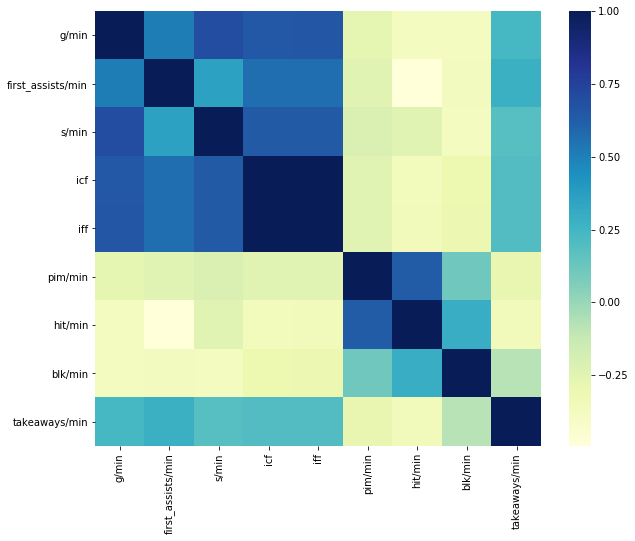

In [41]:
cluster_stats = ['g/min', 'first_assists/min', 's/min', 'icf', 'iff', # offense
                 'pim/min', 'hit/min',                  # physicality
                 'blk/min', 'takeaways/min']           # defense
#first visualize how the /min stats are correlated for forwards
f, ax = plt.subplots(figsize=(10, 8))
corr = forwards_all[cluster_stats].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,cmap="YlGnBu")

There are several stats that are highly correlated and can be combined.

- We don't need to use both Corsi(icf) and Fenwick(iff), they are variations that measure the same thing
- Shots can be dropped and represented by goals
- hit/min or pim/min can be used to measure physicallity

By dropping Corsi/Fenwick, shots/min we have three stats representing offensive skill, one for defensive skill, and two for physicality.

In [42]:
cluster_stats = ['g/min', 'first_assists/min', 'iff', # offense
                 'hit/min',                  # physicality
                 'blk/min', 'takeaways/min']           # defense
forwards_all = cluster_players(forwards_all, cluster_stats, 6, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 5)
Stat           Value     Rank
g/min             -0.87     6/6
first_assists/min   -0.79     5/6
iff               -0.60     5/6
hit/min            0.30     2/6
blk/min            1.44     1/6
takeaways/min     -0.46     4/6

Typical players (0.0%):
('-', 'Mike Fisher')
('-', 'Nick Bonino')
('-', 'Jean-Gabriel Pageau')
('-', 'Matt Read')
('-', 'Tom Pyatt')
--------------------

('Group:', 1, '/', 5)
Stat           Value     Rank
g/min              0.85     2/6
first_assists/min    0.67     2/6
iff                1.30     1/6
hit/min           -0.53     5/6
blk/min           -0.48     5/6
takeaways/min     -0.16     3/6

Typical players (0.0%):
('-', 'Anze Kopitar')
('-', 'Ryan Kesler')
('-', 'Sidney Crosby')
('-', 'Claude Giroux')
('-', 'Evander Kane')
--------------------

('Group:', 2, '/', 5)
Stat           Value     Rank
g/min             -0.17     4/6
first_assists/min   -0.32     4/6
iff               -0.43     4/6
hit/min

In [43]:
# now for the defensemen
defense_adv['last_name'] = defense_adv['name'].apply(lambda l: str.split(l,' ')[-1]) + defense_adv['total_points'].astype(str)
defense['last_name'] = defense['name'].apply(lambda l: str.split(l,' ')[-1]) + defense['pts'].astype(str)
defense_all = pd.merge(defense,defense_adv[['last_name', 'icf', 'iff', 'first_assists/min', 'rush_attempts/min', 'takeaways/min']], how='left', on='last_name')

In [44]:
defense_all = cluster_players(defense_all, cluster_stats, 4, verbose=True)


K-Means Clustering of NHL Players:

('Group:', 0, '/', 3)
Stat           Value     Rank
g/min             -0.12     2/4
first_assists/min   -0.07     2/4
iff               -0.36     3/4
hit/min           -0.43     3/4
blk/min           -0.75     4/4
takeaways/min      0.04     2/4

Typical players (0.0%):
('-', 'Alexander Edler')
('-', 'Alex Goligoski')
('-', 'Jack Johnson')
('-', 'Jay Bouwmeester')
('-', 'David Savard')
--------------------

('Group:', 1, '/', 3)
Stat           Value     Rank
g/min             -0.30     3/4
first_assists/min   -0.41     3/4
iff               -0.29     2/4
hit/min           -0.24     2/4
blk/min            1.07     1/4
takeaways/min     -0.19     3/4

Typical players (0.0%):
('-', 'Francois Beauchemin')
('-', 'Andy Greene')
('-', 'Kris Russell')
('-', 'Travis Hamonic')
('-', 'Ivan Provorov')
--------------------

('Group:', 2, '/', 3)
Stat           Value     Rank
g/min              1.17     1/4
first_assists/min    1.22     1/4
iff                1.3

We can try to differentiate the snipers and playmakers by clustering by goals and assists, with extra emphasis on the ratio between them.


K-Means Clustering of NHL Players:

('Group:', 0, '/', 1)
Stat           Value     Rank
g/min              0.43     1/2
a/min             -0.31     2/2
g/p                2.33     1/2

Typical players (0.0%):
('-', 'John Tavares')
('-', 'Evander Kane')
('-', 'Joe Pavelski')
('-', 'Alex Ovechkin')
('-', 'Steven Stamkos')
--------------------

('Group:', 1, '/', 1)
Stat           Value     Rank
g/min             -0.43     2/2
a/min              0.31     1/2
g/p               -2.33     2/2

Typical players (0.0%):
('-', "Ryan O'Reilly")
('-', 'Patrick Kane')
('-', 'Anze Kopitar')
('-', 'Connor McDavid')
('-', 'Ryan Getzlaf')
--------------------



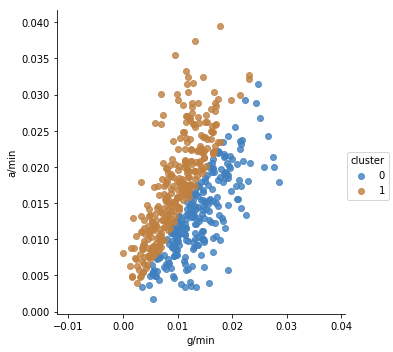

In [45]:
cluster_stats = ['g/min', 'a/min','g/p']
cluster_weights = [1.,1.,3.]
forwards = cluster_players(forwards_all, cluster_stats, 2, cluster_weights, verbose=True)
sns.lmplot(x=cluster_stats[0], y=cluster_stats[1], data=forwards, hue='cluster', fit_reg=False)

In [46]:
forwards_all['off_style'] = forwards['cluster'].apply(lambda l: 'playmaker' if l == 0
                                             else 'sniper')

We can try to classify the offensive-defensive bias. We might be able to use points and blocks as a metric for offense and defense.


K-Means Clustering of NHL Players:

('Group:', 0, '/', 3)
Stat           Value     Rank
pts/min           -0.97     4/4
blk/min            0.70     1/4
s/min             -4.24     4/4

Typical players (0.0%):
('-', 'Travis Zajac')
('-', 'Henrik Sedin')
('-', 'Joe Thornton')
('-', 'Valtteri Filppula')
('-', 'Mike Ribeiro')
--------------------

('Group:', 1, '/', 3)
Stat           Value     Rank
pts/min            1.00     1/4
blk/min           -0.55     4/4
s/min              4.78     1/4

Typical players (0.0%):
('-', 'Patrick Kane')
('-', 'John Tavares')
('-', 'Sidney Crosby')
('-', 'Claude Giroux')
('-', 'Evander Kane')
--------------------

('Group:', 2, '/', 3)
Stat           Value     Rank
pts/min            0.24     2/4
blk/min           -0.33     3/4
s/min              1.06     2/4

Typical players (0.0%):
('-', 'Connor McDavid')
('-', 'Alex Steen')
('-', 'Jonathan Toews')
('-', 'Kyle Turris')
('-', 'Henrik Zetterberg')
--------------------

('Group:', 3, '/', 3)
Stat         

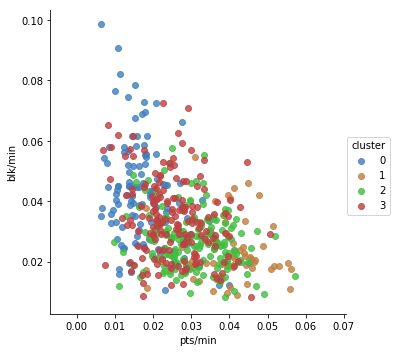

In [47]:
cluster_stats = ['pts/min','blk/min','s/min'] 
cluster_weights = [1.,1.,3.]
forwards_all = cluster_players(forwards_all, cluster_stats, 4, cluster_weights, verbose=True)
sns.lmplot(x=cluster_stats[0], y=cluster_stats[1], data=forwards_all.sort_values(by='cluster'), hue='cluster', fit_reg=False)

In [48]:
forwards_all['bias'] = forwards_all['cluster'].apply(lambda l: 'two way' if l == 0
                                             else 'grinder' if l == 1
                                             else 'defensive' if l == 2
                                             else 'offensive')

We might also be able to determine a player's aggression and physicality by looking at hits and penalties. By using separate stats for minor and major penalties we can differentiate pests from fighters.


K-Means Clustering of NHL Players:

('Group:', 0, '/', 3)
Stat           Value     Rank
hit/min            0.48     2/4
pim/min           -0.16     2/4

Typical players (0.0%):
('-', 'Evander Kane')
('-', 'David Backes')
('-', 'Brandon Dubinsky')
('-', 'Wayne Simmonds')
('-', 'Milan Lucic')
--------------------

('Group:', 1, '/', 3)
Stat           Value     Rank
hit/min           -0.50     3/4
pim/min           -1.19     3/4

Typical players (0.0%):
('-', 'Ryan Kesler')
('-', 'Alex Ovechkin')
('-', 'Gabriel Landeskog')
('-', 'Jordan Staal')
('-', 'Andrew Ladd')
--------------------

('Group:', 2, '/', 3)
Stat           Value     Rank
hit/min           -1.58     4/4
pim/min           -1.44     4/4

Typical players (0.0%):
('-', "Ryan O'Reilly")
('-', 'Patrick Kane')
('-', 'John Tavares')
('-', 'Anze Kopitar')
('-', 'Connor McDavid')
--------------------

('Group:', 3, '/', 3)
Stat           Value     Rank
hit/min            1.61     1/4
pim/min            2.80     1/4

Typical players

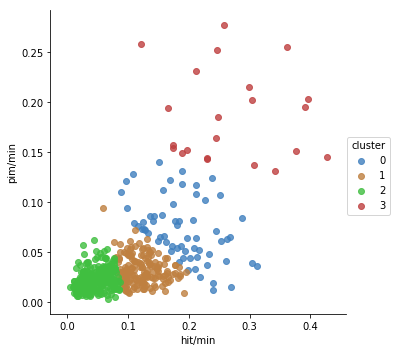

In [49]:
cluster_stats = ['hit/min', 'pim/min'] 
forwards_all = cluster_players(forwards_all, cluster_stats, 4, verbose=True)
sns.lmplot(x=cluster_stats[0], y=cluster_stats[1], data=forwards_all.sort_values(by='cluster'), hue='cluster', fit_reg=False)

In [50]:
forwards['physicality'] = forwards['cluster'].apply(lambda l: 'finesse' if l == 0
                                             else 'agitating' if l == 1 
                                             else 'physical' if l == 2
                                             else 'enforcing')

In [52]:
forwards_all.sort_values('atoi', ascending=False)[['name', 'physicality', 'bias', 'off_style']]

,name,physicality,bias,off_style
435,Ryan O'Reilly,physical,offensive,sniper
394,Patrick Kane,physical,grinder,sniper
240,John Tavares,physical,grinder,playmaker
36,Anze Kopitar,physical,offensive,sniper
116,Connor McDavid,physical,defensive,sniper
430,Ryan Getzlaf,physical,offensive,sniper
433,Ryan Kesler,agitating,offensive,sniper
459,Sidney Crosby,physical,grinder,sniper
107,Claude Giroux,physical,grinder,sniper
174,Evander Kane,finesse,grinder,playmaker
